In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.fft import rfft, irfft, rfftfreq

import analysis_utils as utils
import importlib

In [55]:
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [54]:
importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:110: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz, \n'
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:111: SyntaxWarning: invalid escape sequence '\s'
  f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')


<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

## Check if backscatter detection is shot noise limited (yes)

In [43]:
folder = r'/Users/yuhan/work/nanospheres/data/20240925_force_calibration'
dataset = r''
combined_path = os.path.join(folder, dataset, '20240925_backscatter_*.mat')
data_files = glob.glob(combined_path)

In [44]:
order = [1, 5, 4, 3, 0, 2]
data_files_ordered = [data_files[i] for i in order]

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_11638/3827329260.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(ff/1000, pp, label=f'{lo_power[i]} $\mu$W')


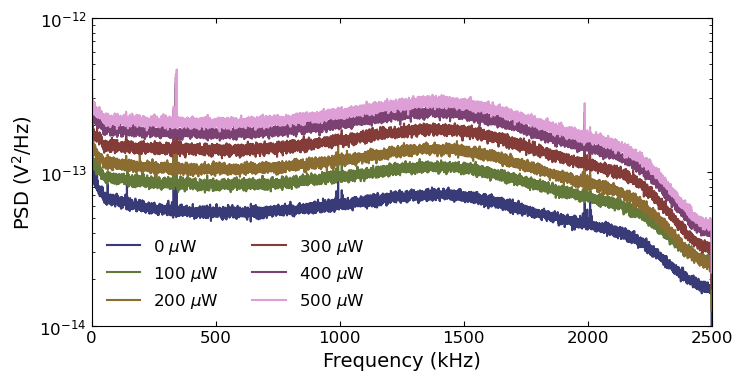

In [57]:
lo_power = [0, 100, 200, 300, 400, 500]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

noise_var = []
for i, file in enumerate(data_files_ordered):
    dtt, tt, nn = utils.load_timestreams(file, ['D'])
    zz = nn[0]
    ff, pp = utils.get_psd(dt=dtt, zz=zz, nperseg=25000)
    
    idx_band = np.logical_and(ff>40000, ff<130000)
    noise_var.append( np.trapz(pp[idx_band], ff[idx_band]*2*np.pi) / (2*np.pi))
    
    ax.plot(ff/1000, pp, label=f'{lo_power[i]} $\mu$W')
    ax.set_yscale('log')
    ax.legend(frameon=False, ncol=2)
    
    ax.set_xlim(0, 2500)
    ax.set_ylim(1e-14, 1e-12)
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('PSD (V$^2$/Hz)')


<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_11638/2863586270.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('LO power ($\mu$W)')


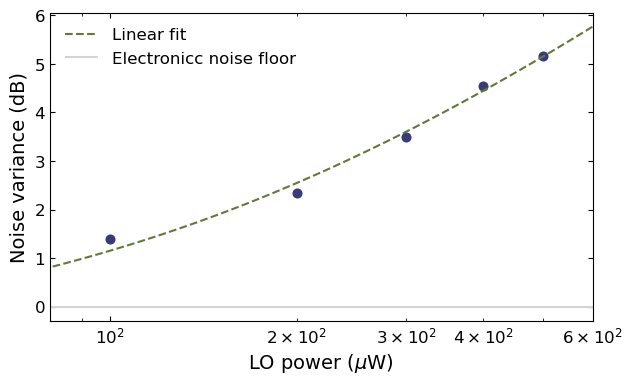

In [93]:
noise_var_db = 10 * np.log10(np.asarray(noise_var[1:]/noise_var[0]))

coef = np.polyfit(lo_power[1:], noise_var[1:]/noise_var[0], 1)
poly1d_fn = np.poly1d(coef)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(lo_power[1:], noise_var_db, '.', markersize=12.5)

pp = np.linspace(50, 600, 100)
ax.plot(pp, 10*np.log10(poly1d_fn(pp)), '--', label='Linear fit')

ax.set_xscale('log')
ax.hlines(0, 50, 600, color='lightgrey', label='Electronicc noise floor')
ax.set_xlim(80, 600)

ax.set_xlabel('LO power ($\mu$W)')
ax.set_ylabel('Noise variance (dB)')
ax.legend(frameon=False)

## Derive the calibration factor

In [182]:
def get_area_driven_peak(ffd, ppd, passband=(88700, 89300), noise_floor=None, plot=False):
    """Calculate PSD then integrate over passband"""
    if noise_floor is None:
        noise_idx = np.logical_and(ffd > 100000, ffd < 105000)
        noise_floor = np.mean(ppd[noise_idx])
    
    all_idx = np.logical_and(ffd > passband[0], ffd < passband[1])
    area_all = np.trapz(ppd[all_idx]-noise_floor, ffd[all_idx]*2*np.pi)
    v2_drive = area_all / (2 * np.pi)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(ffd[all_idx], ppd[all_idx])
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Spectral density ($V^2 / Hz$)')
        ax.set_yscale('log')

    if plot:
        plt.show()

    return v2_drive

In [240]:
folder = r'/Users/yuhan/work/nanospheres/data/20240925_force_calibration'
dataset = r''
combined_path = os.path.join(folder, dataset, '20240925_*_97khz_*.mat')
data_files = glob.glob(combined_path)

In [242]:
order = [4, 3, 2, 1, 0]
data_files_ordered_97khz = [data_files[i] for i in order]

In [238]:
folder = r'/Users/yuhan/work/nanospheres/data/20240925_force_calibration'
dataset = r''
combined_path = os.path.join(folder, dataset, '20240925_*_89khz_*.mat')
data_files = glob.glob(combined_path)

In [235]:
order = [4, 1, 3, 2, 0]
data_files_ordered_89khz = [data_files[i] for i in order]
vp2p = [0.5, 1, 1.5, 2, 2.5]

In [261]:
def get_c_mv(data_files_ordered, vp2p, omegad, passband):
    m = 2000 * (83e-9**3) * (4 / 3) * np.pi  # sphere mass
    
    ffss, ppss = [], []
    for file in data_files_ordered:
        dtt, tt, nn = utils.load_timestreams(file, ['D'])
        zz = nn[0]

        size_per_chunk = int(zz.size / 10)
        ffs, pps = [], []

        for i in range(10):
            ff, pp = utils.get_psd(dt=dtt, zz=zz[i*size_per_chunk : (i+1)*size_per_chunk], nperseg=2**16)
            ffs.append(ff)
            pps.append(pp)

        ffss.append(ffs)
        ppss.append(pps)
        
    c_cals = []
    for i, vpp in enumerate(vp2p):
        fd0 = (vpp / 2) * 120 * 3 * 1.6e-19

        c_cal = []
        for j, ff in enumerate(ffss[i]):
            pp = ppss[i][j]
            v2_drive = get_area_driven_peak(ff, pp, passband=passband, plot=False)

            idx_band = np.logical_and(ff > 40000, ff < 80000)
            omega0 = 2 * np.pi * ff[idx_band][np.argmax(pp[idx_band])]
            z2_drive = (fd0**2 / 2) / ((m * (omega0**2 - omegad**2))**2)

            c_cal.append(v2_drive / z2_drive)
        c_cals.append(c_cal)
    
    return np.sqrt(1 / np.asarray(c_cals))

In [262]:
c_mv_89khz = get_c_mv(data_files_ordered_89khz, vp2p, 89000 * 2 * np.pi, passband=(88700, 89300))
c_mv_97khz = get_c_mv(data_files_ordered_97khz, vp2p, 97000 * 2 * np.pi, passband=(96700, 97300))

In [263]:
means_89khz = np.mean(np.asarray(c_mv_89khz), axis=1)
errors_89khz = np.sqrt(np.var(np.asarray(c_mv_89khz), axis=1) / (10-1))

means_97khz = np.mean(np.asarray(c_mv_97khz), axis=1)
errors_97khz = np.sqrt(np.var(np.asarray(c_mv_97khz), axis=1) / (10-1))

The averaged calibration factor $C_{mV}$ = 9.579e-08


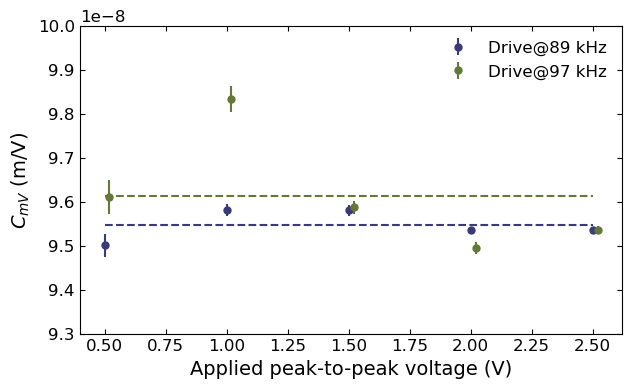

In [577]:
colors = plt.colormaps.get_cmap('tab20b').resampled(6).colors
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.errorbar(vp2p, means_89khz, yerr=errors_89khz, fmt='.', markersize=10, label='Drive@89 kHz')
ax.errorbar(np.asarray(vp2p)+0.02, means_97khz, yerr=errors_97khz, fmt='.', markersize=10, label='Drive@97 kHz')

ax.hlines(np.mean(means_89khz), vp2p[0], vp2p[-1], linestyle='--', color=colors[0])
ax.hlines(np.mean(means_97khz), vp2p[0], vp2p[-1], linestyle='--', color=colors[1])

ax.set_xlabel('Applied peak-to-peak voltage (V)')
ax.set_ylabel('$C_{mV}$ (m/V)')

ax.set_ylim(9.3e-8, 1e-7)
ax.legend(frameon=False)

c_mv = 0.5 * (np.mean(means_89khz) + np.mean(means_97khz))
print(fr'The averaged calibration factor $C_{{mV}}$ = {c_mv:.3e}')

## Calibrated force noise spectrum

In [292]:
file = r'/Users/yuhan/work/nanospheres/data/20240925_force_calibration/20240925_noefield_2e-8mbar.mat'
dtt, tt, nn = utils.load_timestreams(file, ['D'])
fs = int(np.ceil(1/dtt))

zz = nn[0]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_11638/3193373151.py:22: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz\n'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_11638/3193373151.py:23: SyntaxWarning: invalid escape sequence '\s'
  f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')


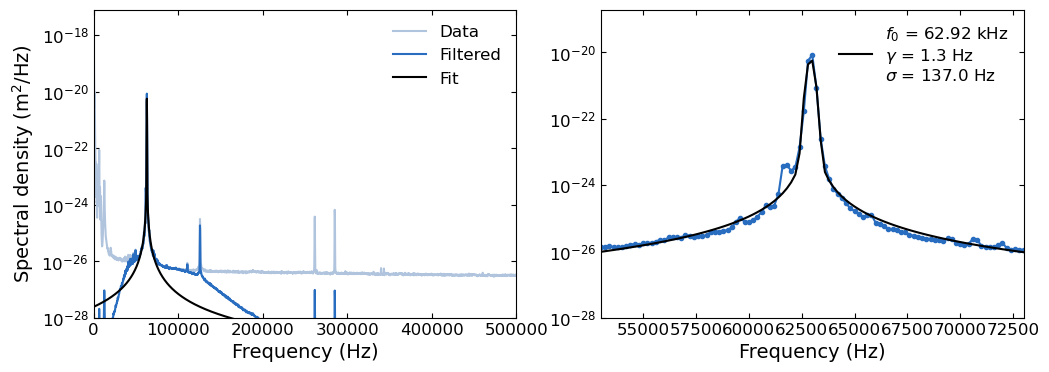

In [295]:
ccal = 1 / (c_mv**2)
ffz, ppz = utils.get_psd(dt=dtt, zz=zz, nperseg=25000)
ffz_bp, ppz_bp = utils.get_psd(dt=dtt, zz=zz_bp, nperseg=25000)

# Fit with a voigt profile
popt = utils.fit_z_peak(ffz_bp, ppz_bp, utils.log_voigt, (53000, 73000), [1e-5, 63000*2*np.pi, 30, 1], False)
omega0, gamma = popt[1], popt[3]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ffz, ppz/ccal, 'lightsteelblue', label='Data')
axes[0].plot(ffz_bp, ppz_bp/ccal, yale_colors[1], label='Filtered')
axes[0].plot(ffz, np.exp(utils.log_voigt(ffz*2*np.pi, *popt))/ccal, 'k', label='Fit')
axes[0].set_yscale('log')
axes[0].set_xlim(0, 500000)
axes[0].set_ylim(1e-28)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Spectral density (m$^2$/Hz)')
axes[0].legend(frameon=False)

label = (f'$f_0$ = {popt[1]/(2*np.pi*1000):.2f} kHz\n'\
         f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz\n'
         f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')
axes[1].plot(ffz_bp, ppz_bp/ccal, yale_colors[1], marker='.')
axes[1].plot(ffz, np.exp(utils.log_voigt(ffz*2*np.pi, *popt))/ccal, 'k', label=label)
axes[1].set_yscale('log')
axes[1].set_xlim(53000, 73000)
axes[1].set_ylim(1e-28)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].legend(frameon=False)

In [558]:
nchunk = 500
size_per_chunk = int(zz.size / nchunk)
ffs, pps = [], []

passband = [30000, 100000]
for i in range(nchunk):
    ff, pp = utils.get_psd(dt=dtt, zz=zz[i*size_per_chunk : (i+1)*size_per_chunk], nperseg=2**16)
    all_idx = np.logical_and(ff > passband[0], ff < passband[1])
    ffs.append(ff[all_idx])
    pps.append(pp[all_idx])

Text(0, 0.5, 'Total force noise (keV/c)')

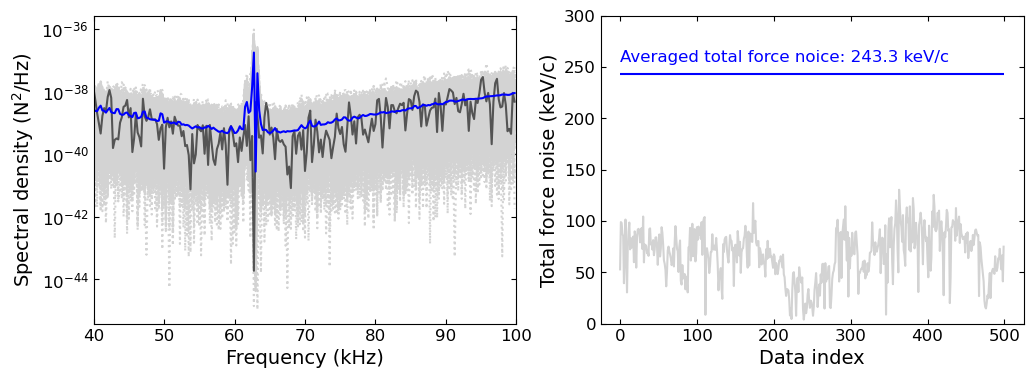

In [570]:
m = 2200 * (83.5e-9)**3 * 4 * np.pi / 3
c = 299792458    # m / s
SI2ev = (1 / 1.6e-19) * c

gamma = 1 * 2 * np.pi

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sig_p = np.empty(len(ffs))

ax = axes[0]
sf_all = []
for i, ff in enumerate(ffs):
    pp = pps[i]
    sz = pp * (c_mv**2)
    
    omega = ff * 2 * np.pi
    omega0 = omega[np.argmax(pp)]
    
    chi = (1 / m) / (omega0**2 - omega**2 - gamma * omega * 1j)
    sf = sz / (np.abs(chi) * np.abs(chi))
    sf_all.append(sf)
    
    sig_p[i] = np.sqrt(1/(np.trapz(1/sf, x=omega)/(2*np.pi))) * SI2ev / 1000
    
    ax.plot(ff/1000, sf, ':', alpha=1, color='lightgrey')

    
ax.plot(ff/1000, sf_all[250], '-', alpha=0.6, color='k')

sf_mean = np.mean(np.asarray(sf_all), axis=0)
sig_p_mean = np.sqrt(1/(np.trapz(1/sf_mean, x=omega)/(2*np.pi))) * SI2ev / 1000

ax.plot(ffs[-1]/1000, sf_mean, 'b')
ax.set_yscale('log')
ax.set_xlim(40, 100)
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Spectral density (N$^2$/Hz)')

ax = axes[1]
ax.plot(sig_p, 'lightgrey')
ax.hlines(sig_p_mean, 0, 500, 'b')
ax.text(0, 255, f'Averaged total force noice: {sig_p_mean:.1f} keV/c', color='b', fontsize=12)

ax.set_ylim(0, 300)
ax.set_xlabel('Data index')
ax.set_ylabel('Total force noise (keV/c)')